In [1]:
import pandas as pd
import numpy as np

In [461]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, KBinsDiscretizer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, accuracy_score
# from sklearn.

In [3]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

### Removing Null values

In [4]:
train_data=train_data.dropna(how='any')

### Adding New Columns

In [5]:
def add_features(X):
    X['Date']=pd.to_datetime(X['CreationTimestamp'], unit='s')
    X['Day']=X['Date'].dt.day_name()
    X['Hour']=X['Date'].apply(lambda x: x.hour + x.minute/60)
    X['ThumbsDifference']=X['ThumbsUpCount']-X['ThumbsDownCount']
    return X

train_data=add_features(train_data)
test_data=add_features(test_data)

### Cleaning Text Features

In [7]:
def clean_text(X):
    replace_dict={'&#34;': '"', '&#39;': "'", '&amp;': 'and', '&gt;': '', '&lt;': ''}
    cleaned=X['Recipe_Review'].str.replace('&.*?;', lambda match: replace_dict[match.group()], regex=True)
    cleaned=cleaned.str.replace(r"'\w+?", "", regex=True)
    X['Recipe_Review']=cleaned
    return X

train_data=clean_text(train_data)
test_data=clean_text(test_data)

In [10]:
train_data=train_data[train_data['ThumbsDifference'] > -75]

In [11]:
train_data.columns

Index(['ID', 'RecipeNumber', 'RecipeCode', 'RecipeName', 'CommentID', 'UserID',
       'UserName', 'UserReputation', 'CreationTimestamp', 'ReplyCount',
       'ThumbsUpCount', 'ThumbsDownCount', 'Rating', 'BestScore',
       'Recipe_Review', 'Date', 'Day', 'Hour', 'ThumbsDifference'],
      dtype='object')

### Dividing data into train and validation

In [13]:
X, y=train_data.drop('Rating', axis=1), train_data['Rating']
X_test=test_data

In [14]:
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, random_state=29)

### Pipeline

In [462]:
col_transform=ColumnTransformer([('scaler', StandardScaler(), ['RecipeNumber', 'UserReputation',
                                                             'ReplyCount', 'ThumbsUpCount',
                                                             'ThumbsDownCount', 'ThumbsDifference', 'BestScore']),
                                 ('hour_encode', KBinsDiscretizer(n_bins=5, encode='onehot',
                                                                 strategy='quantile', random_state=29, subsample=None),
                                                                  ['Hour']),
                                 ('vectorizer', TfidfVectorizer(stop_words='english', max_features=2000), 'Recipe_Review')])

weights={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5, 5: 1.8}
pipeline=Pipeline([('col_transform', col_transform),
                   ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
                   ('clsf', LinearSVC(random_state=29, dual='auto', multi_class='ovr',
                                      loss='hinge', max_iter=33310, class_weight=weights,
                                      C=0.035, intercept_scaling=8))])

In [463]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transform',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['RecipeNumber',
                                                   'UserReputation',
                                                   'ReplyCount',
                                                   'ThumbsUpCount',
                                                   'ThumbsDownCount',
                                                   'ThumbsDifference',
                                                   'BestScore']),
                                                 ('hour_encode',
                                                  KBinsDiscretizer(random_state=29,
                                                                   subsample=None),
                                                  ['Hour']),
                                                 ('vectorizer',
                                                  TfidfVectorizer(max_features=2000,
                                                                  stop_words='english'),
                                                  'Recipe_Review')])),
                ('dense',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x000001E4039ED7E0>)),
                ('clsf',
                 LinearSVC(C=0.035,
                           class_weight={0: 4, 1: 8, 2: 12, 3: 6, 4: 3.5,
                                         5: 1.8},
                           dual='auto', intercept_scaling=8, loss='hinge',
                           max_iter=33310, random_state=29))])

In [464]:
pipeline.named_steps['clsf'].intercept_

array([-0.43530499, -1.07640435, -0.97057433, -0.97142971, -0.95805596,
        0.87004465])

### Train Report

In [465]:
train_predict=pipeline.predict(X_train)

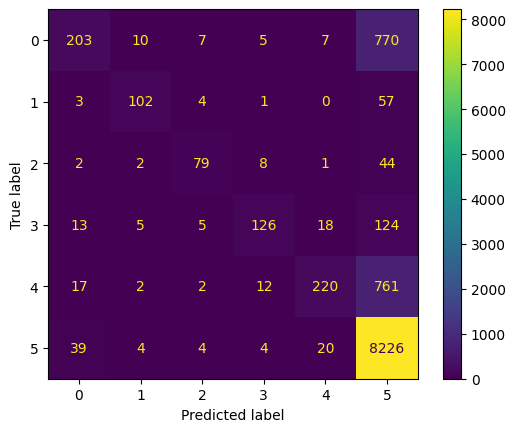

In [466]:
ConfusionMatrixDisplay.from_predictions(y_train, train_predict, display_labels=pipeline.classes_);

In [467]:
print(classification_report(y_train, train_predict))

              precision    recall  f1-score   support

           0       0.73      0.20      0.32      1002
           1       0.82      0.61      0.70       167
           2       0.78      0.58      0.67       136
           3       0.81      0.43      0.56       291
           4       0.83      0.22      0.34      1014
           5       0.82      0.99      0.90      8297

    accuracy                           0.82     10907
   macro avg       0.80      0.51      0.58     10907
weighted avg       0.81      0.82      0.78     10907



In [468]:
accuracy_score(y_train, train_predict)

0.8211240487760154

### Test Report

In [469]:
valid_predict=pipeline.predict(X_valid)

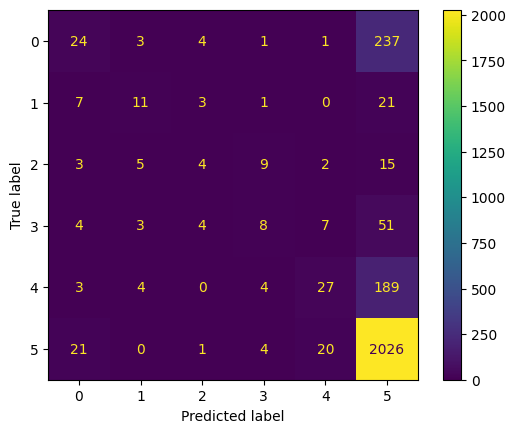

In [470]:
ConfusionMatrixDisplay.from_predictions(y_valid, valid_predict, display_labels=pipeline.classes_);

In [471]:
print(classification_report(y_valid, valid_predict, zero_division=0))

              precision    recall  f1-score   support

           0       0.39      0.09      0.14       270
           1       0.42      0.26      0.32        43
           2       0.25      0.11      0.15        38
           3       0.30      0.10      0.15        77
           4       0.47      0.12      0.19       227
           5       0.80      0.98      0.88      2072

    accuracy                           0.77      2727
   macro avg       0.44      0.28      0.31      2727
weighted avg       0.70      0.77      0.71      2727



In [472]:
accuracy_score(y_valid, valid_predict)

0.77007700770077

### Grid Search

In [94]:
gscv=GridSearchCV(pipeline, param_grid={'clsf__C' : [0.6, 0.65, 0.7, 0.75, 0.8]}, cv=4, n_jobs=-1)
gscv.fit(X_train, y_train)
gscv.best_params_, gscv.best_score_

({'clsf__C': 0.7}, 0.7668961320196583)

### Training on whole dataset

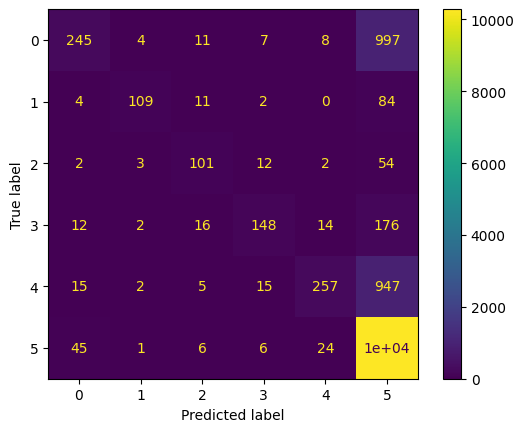

In [416]:
pipeline.fit(X, y)
whole_predict=pipeline.predict(X)
ConfusionMatrixDisplay.from_predictions(y, whole_predict, display_labels=pipeline.classes_);

In [417]:
print(classification_report(y, whole_predict))

              precision    recall  f1-score   support

           0       0.76      0.19      0.31      1272
           1       0.90      0.52      0.66       210
           2       0.67      0.58      0.62       174
           3       0.78      0.40      0.53       368
           4       0.84      0.21      0.33      1241
           5       0.82      0.99      0.90     10369

    accuracy                           0.82     13634
   macro avg       0.80      0.48      0.56     13634
weighted avg       0.81      0.82      0.77     13634



In [418]:
accuracy_score(y, whole_predict)

0.817588381986211

In [338]:
test_predict=pipeline.predict(X_test)